In [1]:
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from p2ch13.dsets import getCandidateInfoList, getCt, TrainingLuna2dSegmentationDataset, CandidateInfoTuple
from p2ch13.model import SegmentationMask, MaskTuple
from p2ch13.vis import build2dLungMask
from util.util import xyz2irc

In [2]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
candidateInfo_list[0]

CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.82725575, 85.37992457, -109.74672379999998))

In [3]:
series_list = sorted(set(t.series_uid for t in candidateInfo_list))

In [ ]:
ds = TrainingLuna2dSegmentationDataset(
            val_stride=10,
            isValSet_bool=False,
            contextSlices_count=3,
        )

def _ds_iter():
    for i in range(len(ds)):
        yield ds[i]

ds_iter = _ds_iter()

2025-07-17 14:54:26,781 INFO     pid:8732 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x000001C8AE28B8E0>: 799 training series, 8343 slices, 1028 nodules


In [ ]:
def show_positive_slices_grid(uid, max_samples=9):
    dataset = TrainingLuna2dSegmentationDataset(series_uid=uid)
    ct = getCt(uid)

    candidate_list = getCandidateInfoList()

    cand_per_slice = {}
    for cand in candidate_list:
        if cand.series_uid == uid and cand.isNodule_bool:
            center_irc = xyz2irc(cand.center_xyz, ct.origin_xyz, ct.vxSize_xyz, np.eye(3))  # direction_a → eye(3)
            slice_idx = int(round(center_irc[0]))
            if slice_idx not in cand_per_slice:
                cand_per_slice[slice_idx] = []
            cand_per_slice[slice_idx].append(cand.diameter_mm)

    positive_samples = []
    for i in range(len(dataset)):
        ct_t, mask_t, series_uid, slice_index = dataset[i]
        if mask_t.sum() > 0:
            diameters = cand_per_slice.get(slice_index, [])
            positive_samples.append((ct_t[0].numpy(), mask_t[0].numpy(), diameters, slice_index))
            if len(positive_samples) >= max_samples:
                break
    num_samples = len(positive_samples)
    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))

    for i, (ct_slice, mask_slice, diameters, slice_index) in enumerate(positive_samples):
        r, c = divmod(i, cols)
        ax = axs[r][c] if rows > 1 else axs[c]
        ax.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
        ax.imshow(mask_slice, cmap='Reds', alpha=0.3)
        
        if diameters:
            diam_str = ', '.join([f'{d:.1f}' for d in diameters])
            title = f'Slice {slice_index} (Nodule)\nDiam: {diam_str} mm'
        else:
            title = f'Slice {slice_index} (Nodule)'
        ax.set_title(title)
        ax.axis('off')

    for j in range(num_samples, rows * cols):
        r, c = divmod(j, cols)
        ax = axs[r][c] if rows > 1 else axs[c]
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Positive Nodule Slices - UID: {uid}', y=1.02)
    plt.show()

2025-07-17 14:54:26,865 INFO     pid:8732 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x000001C89A8ABDF0>: 1 general series, 29 slices, 9 nodules


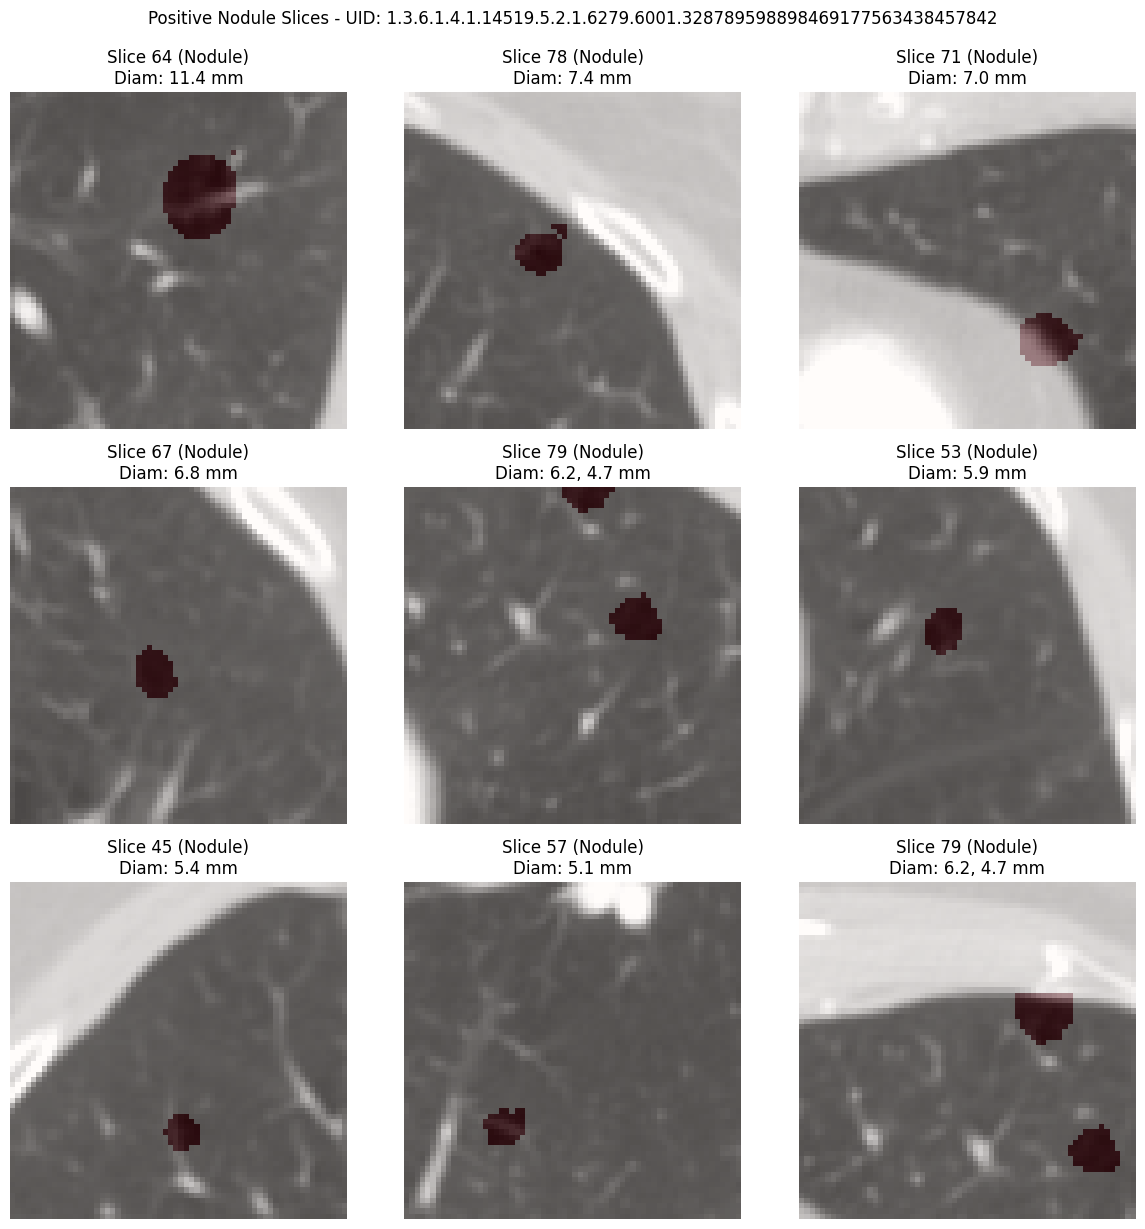

In [6]:
show_positive_slices_grid("1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842")

In [ ]:
model = UNetWrapper(
    in_channels=7,
    n_classes=1,
    depth=3,
    wf=4,
    padding=False,
    batch_norm=True,
    up_mode='upconv'
)


model_path = "data-unversioned/part2/models/p2ch13/seg_2025-07-15_09.20.51_none.3000000.state"
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint["model_state"])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

UNetWrapper(
  (input_batchnorm): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (unet): UNet(
    (down_path): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(7, 16, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
          (4): ReLU()
          (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (4): ReLU()
          (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

In [8]:
def show_single_slice_with_masks(ct_tensor, mask_tensor, series_uid, slice_index, model, device, diameters=None, threshold=0.5):
    model.eval()
    with torch.no_grad():
        input_tensor = ct_tensor.unsqueeze(0).to(device)  # [1, 7, H, W]
        pred_mask = model(input_tensor).squeeze().cpu().numpy()  # [H, W]

    ct_slice = ct_tensor[3].numpy()
    gt_mask = mask_tensor[0].numpy() if mask_tensor.dim() == 3 else mask_tensor.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
    axs[0].set_title(f"Slice {slice_index} - CT")
    axs[0].axis('off')

    axs[1].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
    axs[1].imshow(gt_mask, cmap='Reds', alpha=0.3)
    title = f"Ground Truth"
    if diameters:
        title += f"\nDiameter: {', '.join([f'{d:.1f}mm' for d in diameters])}"
    axs[1].set_title(title)
    axs[1].axis('off')

    axs[2].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
    axs[2].imshow(pred_mask > threshold, cmap='Blues', alpha=0.3)
    axs[2].set_title(f"Model Prediction\n(Threshold: {threshold})")
    axs[2].axis('off')

    plt.tight_layout()
    plt.suptitle(f"{series_uid}", y=1.05)
    plt.show()

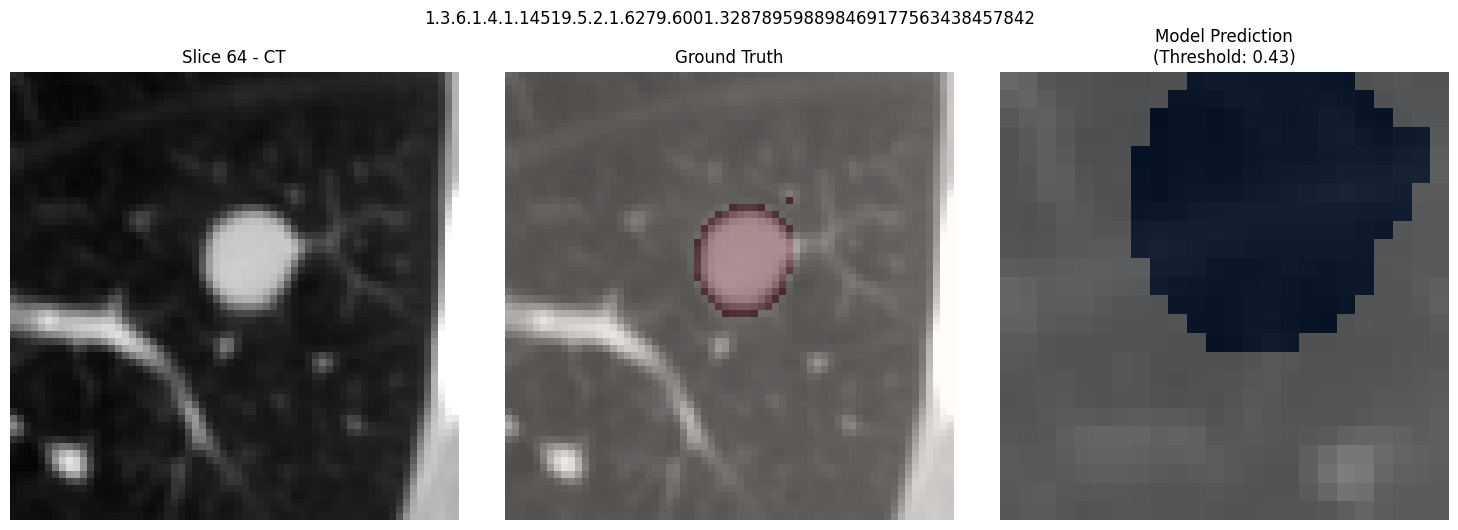

In [10]:
ct_tensor, mask_tensor, series_uid, slice_index = dataset[0]

show_single_slice_with_masks(ct_tensor, mask_tensor, series_uid, slice_index, model, device, threshold=0.43)

In [ ]:
def show_tp_fp_fn(ct_tensor, mask_tensor, series_uid, slice_index, model, device, threshold=0.5):

    model.eval()
    with torch.no_grad():
        input_tensor = ct_tensor.unsqueeze(0).to(device) 
        pred_mask = model(input_tensor).squeeze().cpu().numpy() 

    gt_mask = mask_tensor[0].numpy() if mask_tensor.ndim == 3 else mask_tensor.numpy()  # [H, W]
    if pred_mask.shape != gt_mask.shape:
        pred_mask = zoom(pred_mask,
                         (gt_mask.shape[0] / pred_mask.shape[0],
                          gt_mask.shape[1] / pred_mask.shape[1]),
                         order=1)

    binary_pred = pred_mask > threshold

    tp = (binary_pred == 1) & (gt_mask == 1)
    fp = (binary_pred == 1) & (gt_mask == 0)
    fn = (binary_pred == 0) & (gt_mask == 1)

    vis_mask = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
    vis_mask[tp] = [0, 255, 0]     # 초록
    vis_mask[fp] = [0, 0, 255]     # 파랑
    vis_mask[fn] = [255, 0, 0]     # 빨강

    ct_slice = ct_tensor[3].numpy()  


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
    axs[0].set_title(f"CT Slice (index={slice_index})")
    axs[0].axis('off')

    axs[1].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
    axs[1].imshow(vis_mask, alpha=0.5)
    axs[1].set_title(f"TP(G) / FP(B) / FN(R)\n(Threshold: {threshold})")
    axs[1].axis('off')

    plt.tight_layout()
    plt.suptitle(f"{series_uid}", y=1.05)
    plt.show()

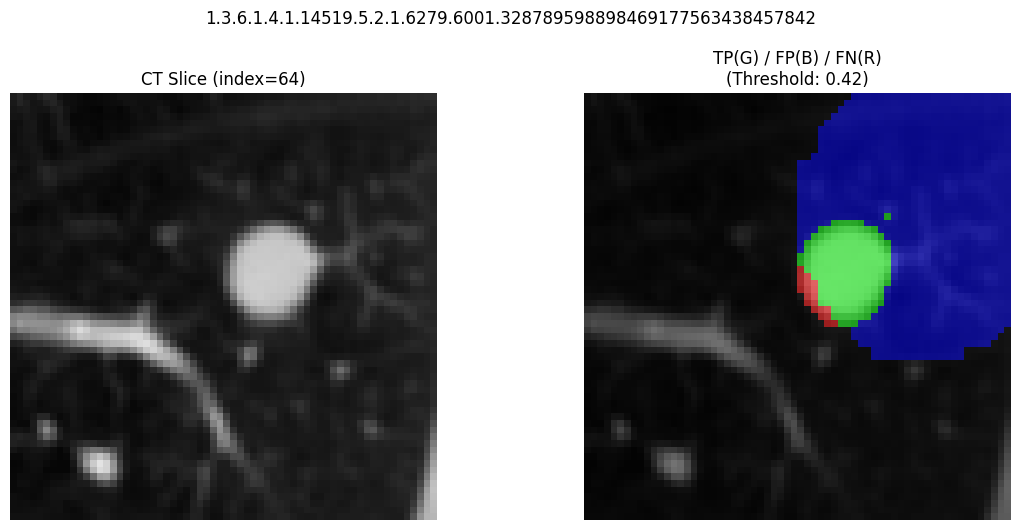

In [12]:
ct_tensor, mask_tensor, series_uid, slice_index = dataset[0]

show_tp_fp_fn(ct_tensor, mask_tensor, series_uid, slice_index, model, device, threshold=0.42)

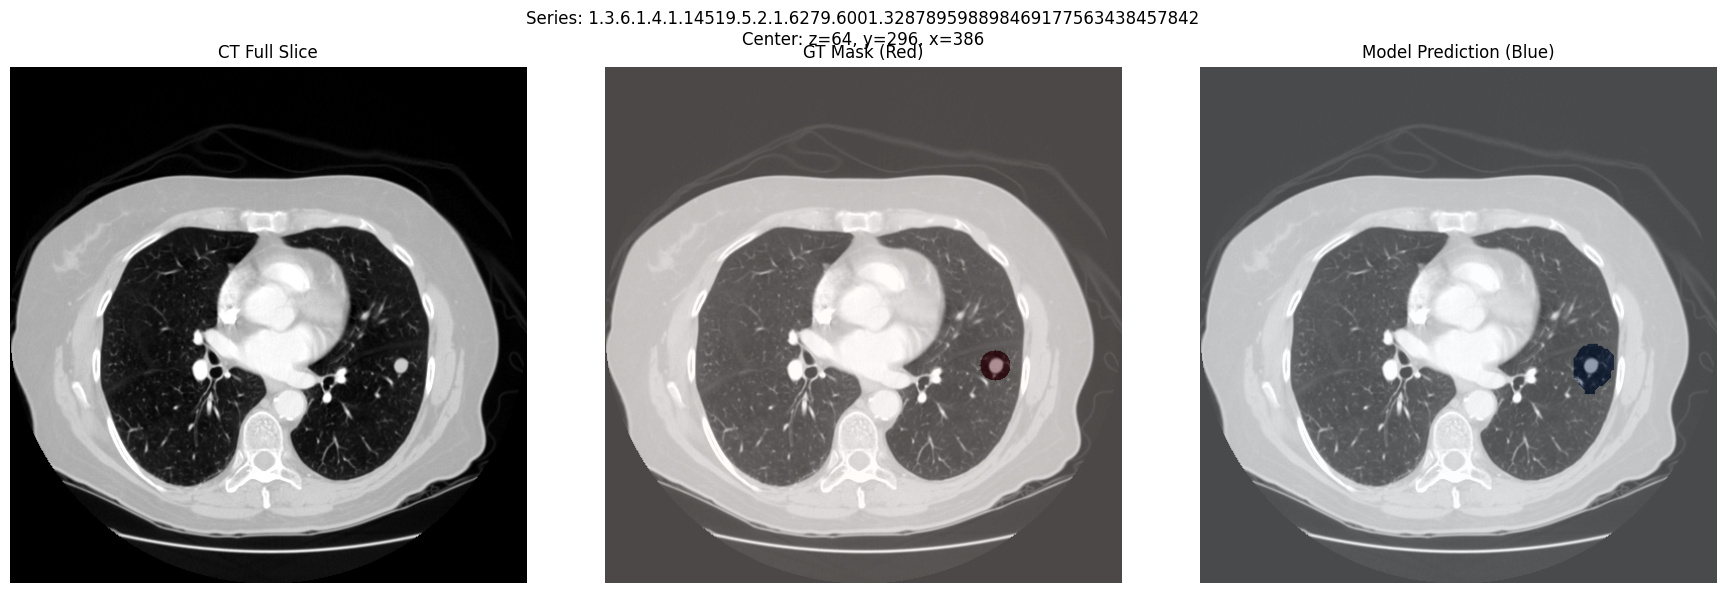

<Figure size 640x480 with 0 Axes>

In [ ]:
series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"

candidate_list = getCandidateInfoList()

candidate = [c for c in candidate_list if c.series_uid == series_uid and c.isNodule_bool][0]

ct = getCt(series_uid)

center_irc = xyz2irc(candidate.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
z, y, x = map(int, center_irc)


ct_slice = ct.hu_a[z]  

gt_mask = np.zeros_like(ct_slice, dtype=np.uint8)
r = max(3, int(candidate.diameter_mm / ct.vxSize_xyz[1]))  
yy, xx = np.ogrid[:ct_slice.shape[0], :ct_slice.shape[1]]
mask_area = (yy - y)**2 + (xx - x)**2 <= r**2
gt_mask[mask_area] = 1

crop = ct.hu_a[z - 3:z + 4, y - 32:y + 32, x - 32:x + 32]  
input_tensor = torch.from_numpy(crop).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(input_tensor)  
    pred_resized = F.interpolate(pred, size=(64, 64), mode='bilinear', align_corners=False)
    pred_mask = pred_resized.squeeze().cpu().numpy() > 0.5  

pred_full = np.zeros_like(ct_slice, dtype=np.uint8)
pred_full[y - 32:y + 32, x - 32:x + 32] = pred_mask

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[0].set_title("CT Full Slice")

axs[1].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[1].imshow(gt_mask, cmap='Reds', alpha=0.3)
axs[1].set_title("GT Mask (Red)")

axs[2].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[2].imshow(pred_full, cmap='Blues', alpha=0.3)
axs[2].set_title("Model Prediction (Blue)")

for ax in axs:
    ax.axis('off')

plt.suptitle(f"Series: {series_uid}\nCenter: z={z}, y={y}, x={x}")
plt.tight_layout()
plt.show()
for ax in axs:
    ax.axis('off')

plt.suptitle(f"Series: {series_uid}\nCenter: z={z}, y={y}, x={x}")
plt.tight_layout()
plt.show()

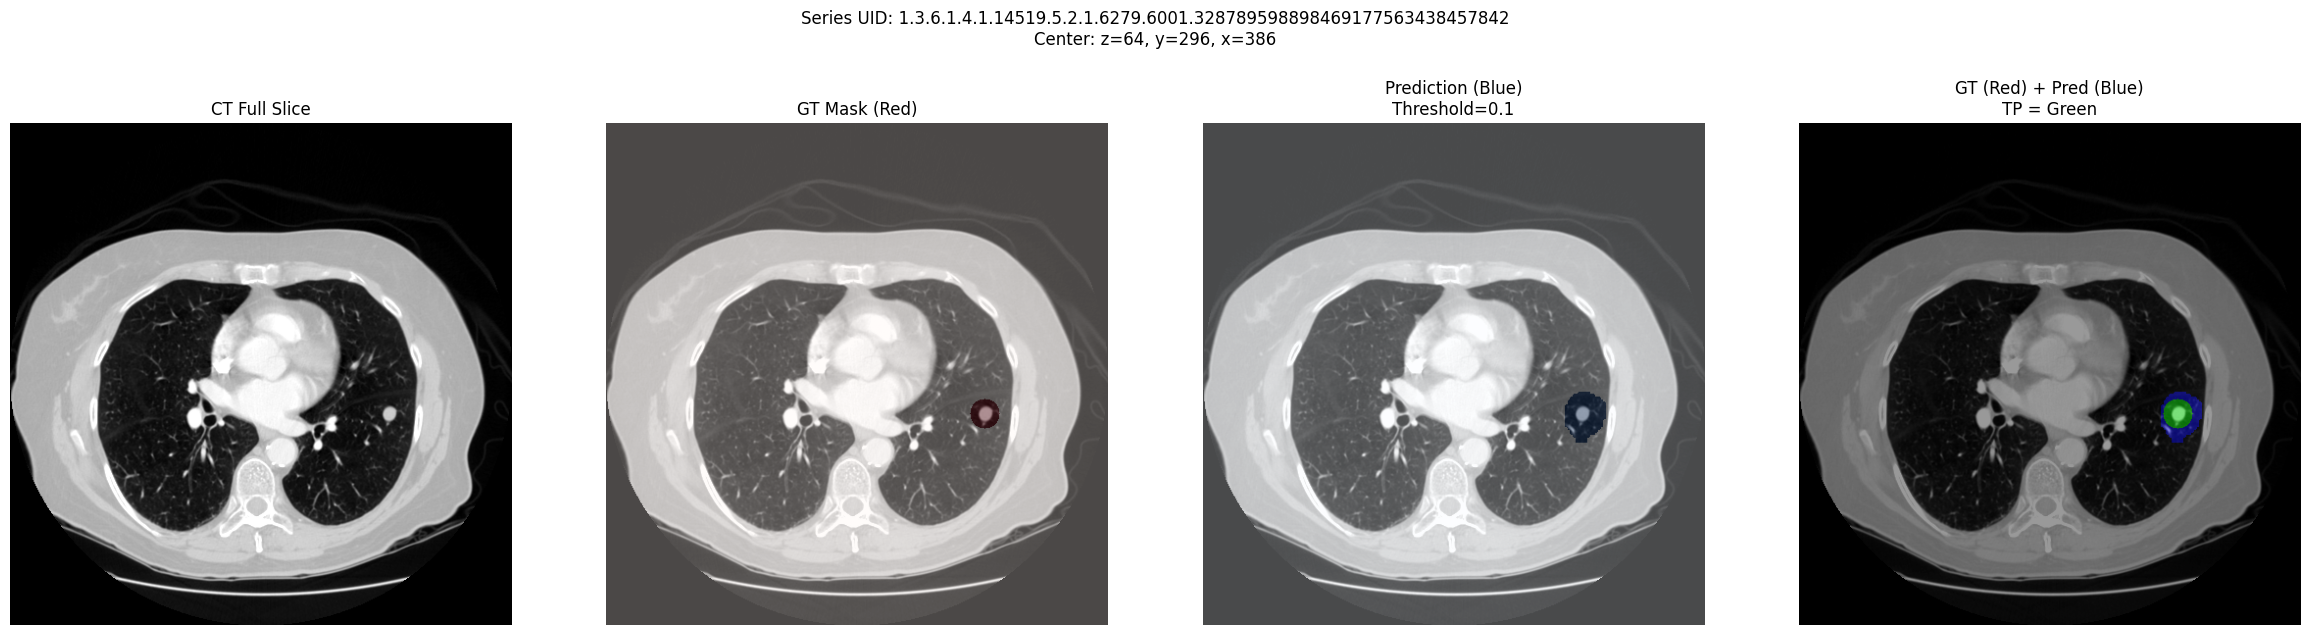

In [ ]:
series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
threshold = 0.1 

candidate = [c for c in getCandidateInfoList() if c.series_uid == series_uid and c.isNodule_bool][0]
ct = getCt(series_uid)
center_irc = xyz2irc(candidate.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
z, y, x = map(int, center_irc)
ct_slice = ct.hu_a[z]  


gt_mask = np.zeros_like(ct_slice, dtype=np.uint8)
r = max(3, int(candidate.diameter_mm / ct.vxSize_xyz[1]))  
yy, xx = np.ogrid[:ct_slice.shape[0], :ct_slice.shape[1]]
mask_area = (yy - y)**2 + (xx - x)**2 <= r**2
gt_mask[mask_area] = 1

crop = ct.hu_a[z - 3:z + 4, y - 32:y + 32, x - 32:x + 32]  
input_tensor = torch.from_numpy(crop).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(input_tensor)  
    pred_resized = F.interpolate(pred, size=(64, 64), mode='bilinear', align_corners=False)
    pred_mask = pred_resized.squeeze().cpu().numpy() > threshold  # 🔸 threshold 적용


pred_full = np.zeros_like(ct_slice, dtype=np.uint8)
pred_full[y - 32:y + 32, x - 32:x + 32] = pred_mask


overlay = np.zeros((*ct_slice.shape, 3), dtype=np.uint8)
overlay[gt_mask == 1] = [255, 0, 0]        
overlay[pred_full == 1] = [0, 0, 255]       
overlay[(gt_mask == 1) & (pred_full == 1)] = [0, 255, 0]  


fig, axs = plt.subplots(1, 4, figsize=(24, 6))

axs[0].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[0].set_title("CT Full Slice")

axs[1].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[1].imshow(gt_mask, cmap='Reds', alpha=0.3)
axs[1].set_title("GT Mask (Red)")

axs[2].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[2].imshow(pred_full, cmap='Blues', alpha=0.3)
axs[2].set_title(f"Prediction (Blue)\nThreshold={threshold}")

axs[3].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
axs[3].imshow(overlay, alpha=0.4)
axs[3].set_title("GT (Red) + Pred (Blue)\nTP = Green")

for ax in axs:
    ax.axis('off')

plt.suptitle(f"Series UID: {series_uid}\nCenter: z={z}, y={y}, x={x}", y=1.05)
plt.tight_layout()
plt.show()

## z,y,x축 슬라이스

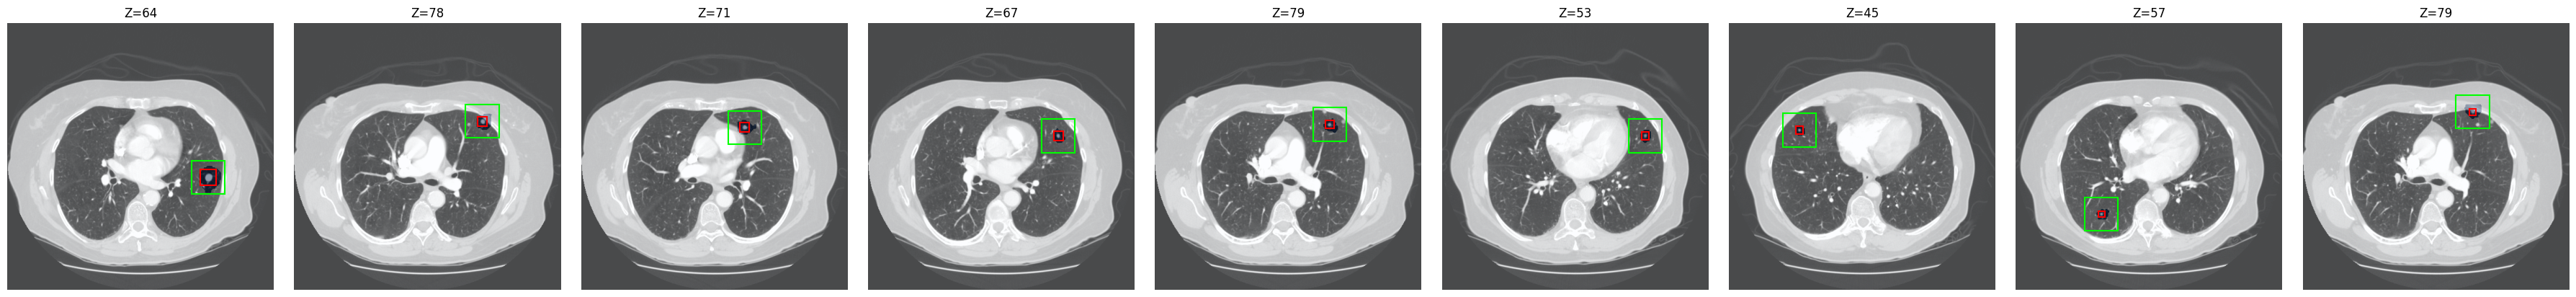

In [25]:
series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
ct = getCt(series_uid)
candidate_list = [c for c in getCandidateInfoList() if c.series_uid == series_uid and c.isNodule_bool]

show_bbox_prediction(ct, candidate_list, model)

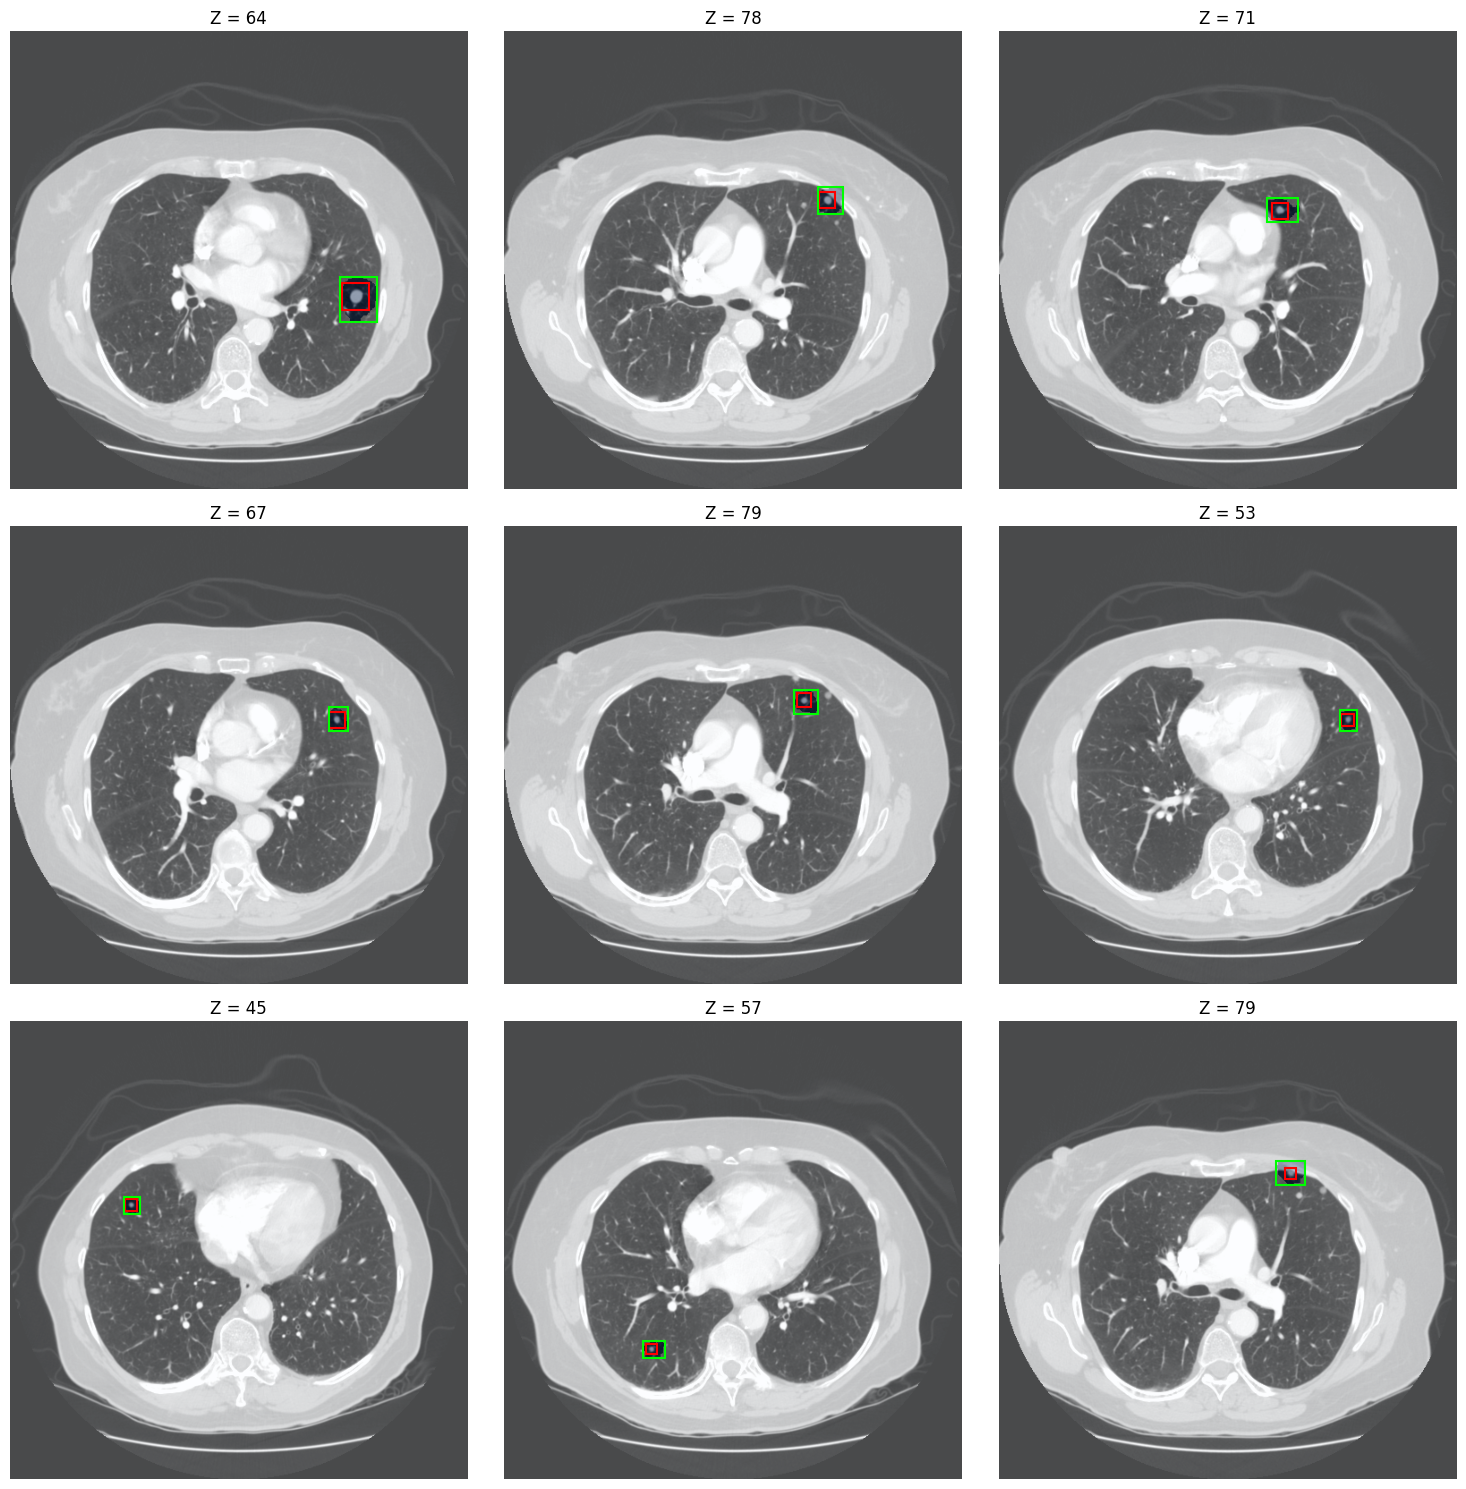

In [27]:
series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
ct = getCt(series_uid)
candidate_list = [c for c in getCandidateInfoList() if c.series_uid == series_uid and c.isNodule_bool]

show_pred_bbox(ct, candidate_list, model)

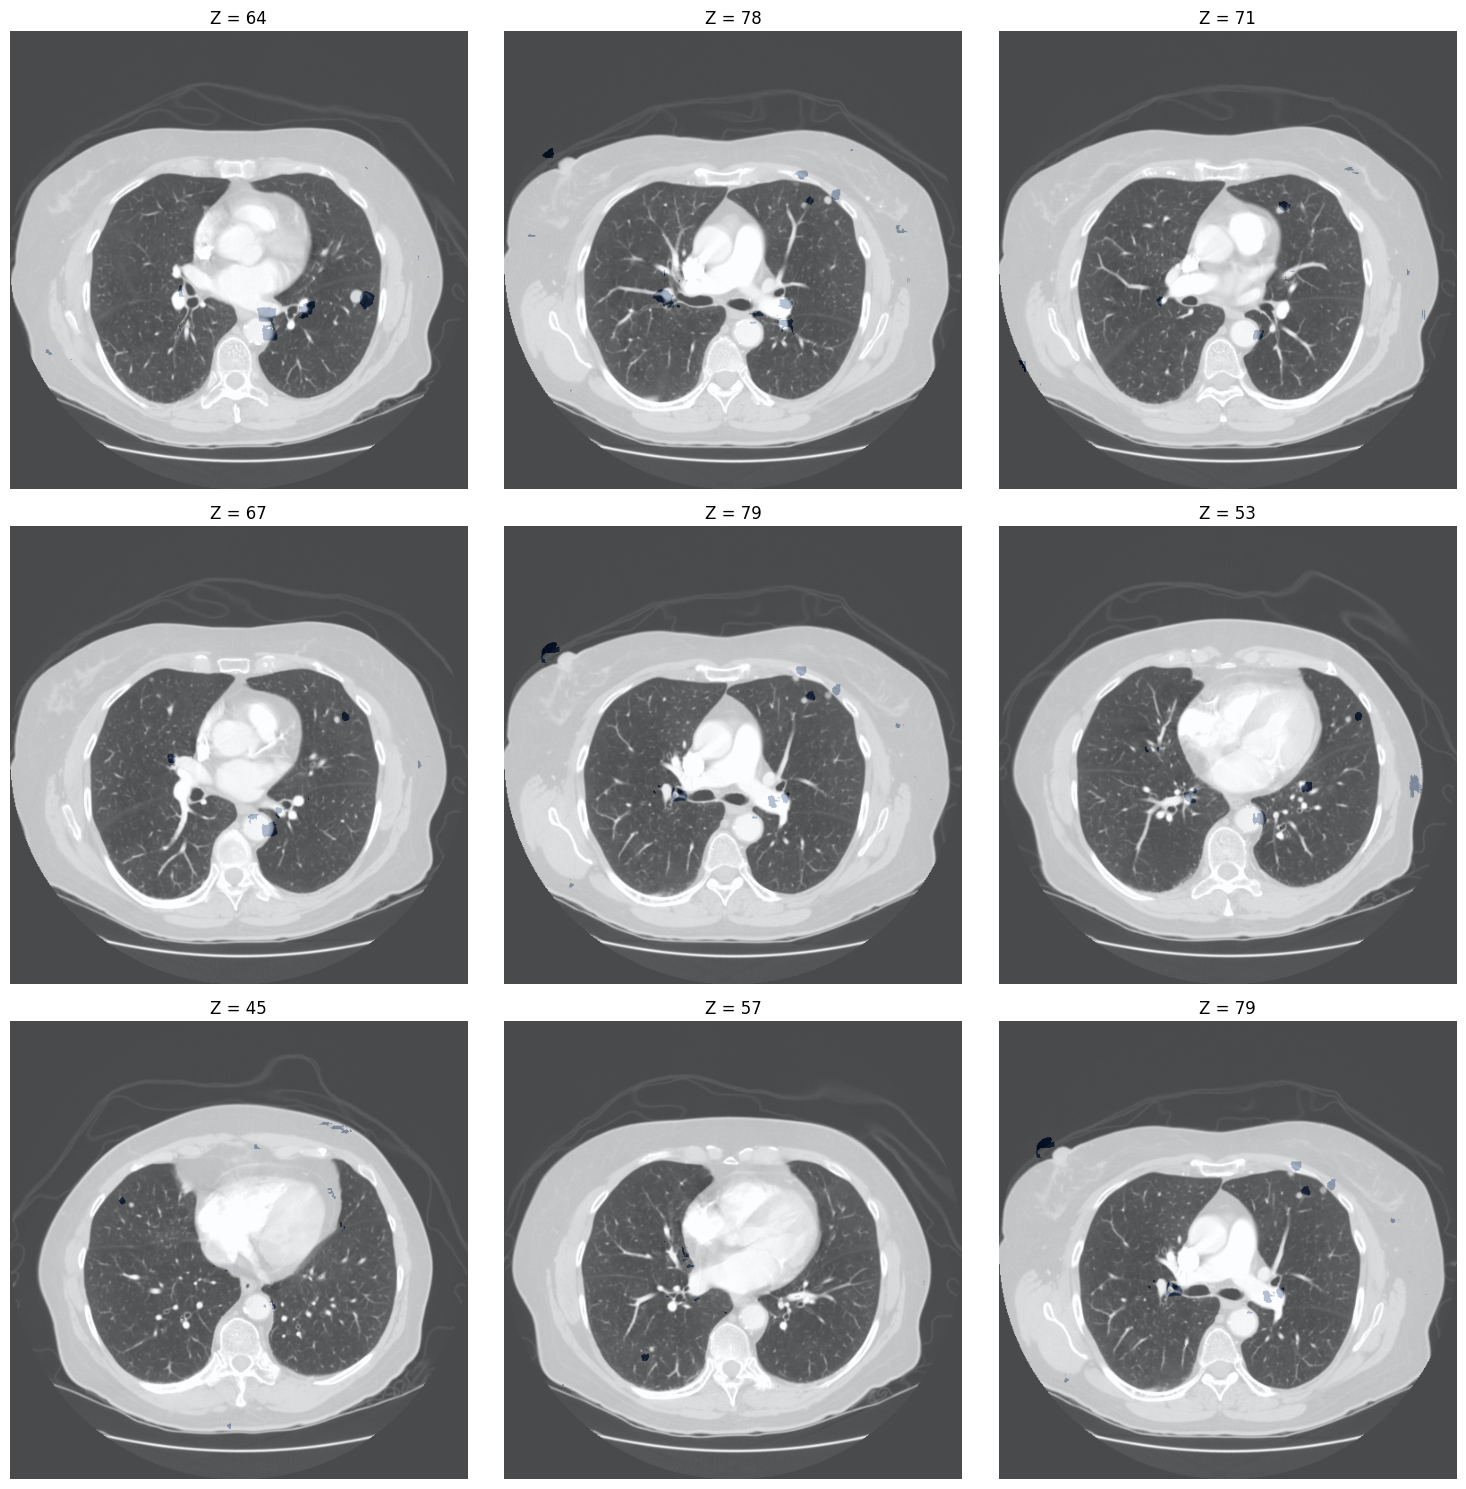

In [43]:
import torch.nn.functional as F
import numpy as np
import torch

z_list = []
for c in candidate_list:
    center_irc = xyz2irc(c.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
    z = int(center_irc[0])
    if 0 <= z < ct.hu_a.shape[0]:  # 유효한 범위 내일 때만 추가
        z_list.append(z)
def get_full_volume_prediction(ct, model):
    D, H, W = ct.hu_a.shape
    pred_volume = np.zeros((D, H, W), dtype=np.float32)

    model.eval()
    with torch.no_grad():
        for z in range(3, D - 3):  # 양 끝 제외
            slices = ct.hu_a[z - 3: z + 4]  # 7개 슬라이스
            input_tensor = torch.from_numpy(slices).float().unsqueeze(0).to(next(model.parameters()).device)  # [1, 7, H, W]

            pred = model(input_tensor)  # [1, 1, h', w']
            pred_resized = F.interpolate(pred, size=(H, W), mode='bilinear', align_corners=False)
            pred_np = pred_resized.squeeze().cpu().numpy()  # [H, W]

            pred_volume[z] = pred_np

    return pred_volume
pred_volume = get_full_volume_prediction(ct, model)
binary_volume = (pred_volume > 0.5).astype(np.uint8)

show_3d_prediction(ct.hu_a, pred_volume, z_list, threshold=0.5)

2025-07-17 15:16:43,426 DEBUG    pid:8732 p2ch14.nodule_analysis:211:initModels data-unversioned/part2/models/p2ch13/seg_2025-07-17_13.42.03_augmented.best.state
2025-07-17 15:16:43,495 DEBUG    pid:8732 p2ch14.nodule_analysis:227:initModels data/part2/models/cls_2020-02-06_14.16.55_final-nodule-nonnodule.best.state


Total slices: 128, Visualizing slice: 64


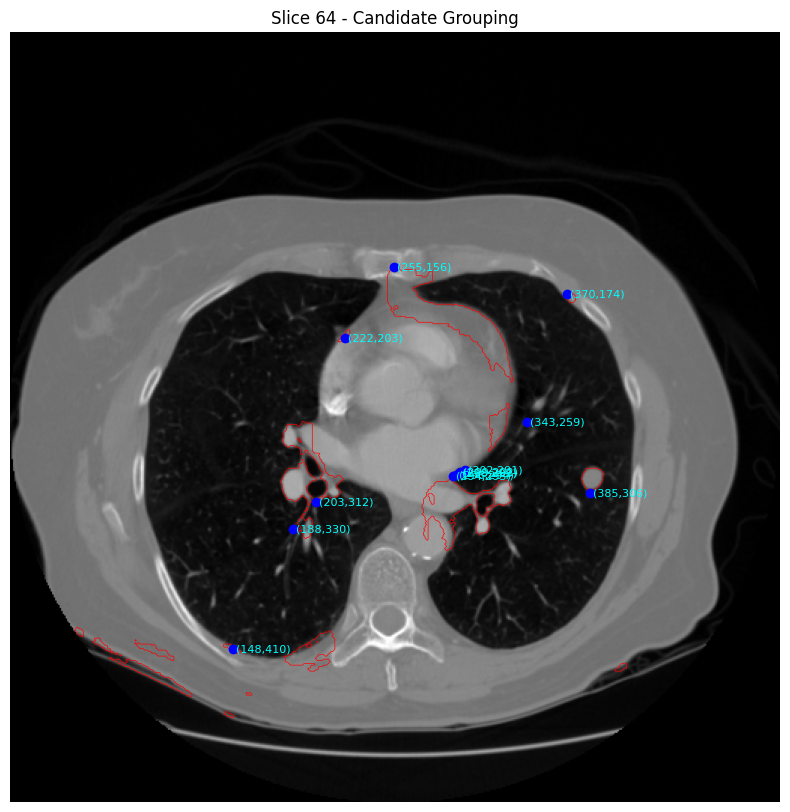

In [ ]:
uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842'
seg_path = 'data-unversioned/part2/models/p2ch13/seg_2025-07-17_13.42.03_augmented.best.state'

app = NoduleAnalysisApp([
    uid,
    '--segmentation-path', seg_path
])

ct = getCt(uid)

mask_a = app.segmentCt(ct, uid)

candidateInfo_list = app.groupSegmentationOutput(uid, ct, mask_a)

def show_candidate_grouping(ct, mask_a, candidateInfo_list, slice_idx):
    fig, ax = plt.subplots(figsize=(10, 10))

    image_slice = np.clip(ct.hu_a[slice_idx], -1000, 1000)
    ax.imshow(image_slice, cmap='gray')
    ax.contour(mask_a[slice_idx], colors='r', linewidths=0.5)

    for cand in candidateInfo_list:
        center_xyz = cand.center_xyz
        center_irc = xyz2irc(center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
        z, y, x = map(int, center_irc)

        if z == slice_idx:
            ax.plot(x, y, 'bo', markersize=6)
            ax.text(x + 2, y + 2, f"({x},{y})", color='cyan', fontsize=8)

    ax.set_title(f"Slice {slice_idx} - Candidate Grouping")
    plt.axis('off')
    plt.show()


z_max = ct.hu_a.shape[0]
middle_z = z_max // 2
print(f"Total slices: {z_max}, Visualizing slice: {middle_z}")
show_candidate_grouping(ct, mask_a, candidateInfo_list, slice_idx=middle_z)

In [33]:
from scipy.ndimage import center_of_mass
from math import sqrt

def compare_gt_pred_centers(ct, candidate_list, pred_volume, threshold=0.3):
    results = []

    for candidate in candidate_list:
        center_irc = xyz2irc(candidate.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
        z, y, x = map(int, center_irc)

        pred_mask = pred_volume[z]

        if (pred_mask > threshold).sum() == 0:
            pred_center = None
            distance_pix = None
            distance_mm = None
        else:
            py, px = center_of_mass(pred_mask > threshold)
            pred_center = (int(py), int(px))

            # 거리 (픽셀 단위)
            distance_pix = sqrt((py - y)**2 + (px - x)**2)

            # 거리 (mm 단위) - y, x축 voxel size 적용
            vy, vx = ct.vxSize_xyz[1:3]
            distance_mm = sqrt(((py - y)*vy)**2 + ((px - x)*vx)**2)

        results.append({
            'Z': z,
            'GT_center': (y, x),
            'Pred_center': pred_center,
            'Distance_pix': distance_pix,
            'Distance_mm': distance_mm
        })

    return results


In [ ]:
results = compare_gt_pred_centers(ct, candidate_list, pred_volume, threshold=0.3)

for i, r in enumerate(results):
    print(f"[결절 {i+1}] Z = {r['Z']}")
    print(f"   GT 중심:    {r['GT_center']}")
    if r['Pred_center']:
        print(f"   Pred 중심:  {r['Pred_center']}")
        print(f"   거리:       {r['Distance_pix']:.2f} pixels / {r['Distance_mm']:.2f} mm")
    else:
        print(f"   예측 없음")

[결절 1] Z = 64
   GT 중심:    (296, 386)
   Pred 중심:  (297, 388)
   거리:       3.37 pixels / 6.99 mm
[결절 2] Z = 78
   GT 중심:    (188, 361)
   Pred 중심:  (188, 364)
   거리:       3.35 pixels / 8.12 mm
[결절 3] Z = 71
   GT 중심:    (200, 314)
   Pred 중심:  (199, 314)
   거리:       0.64 pixels / 1.56 mm
[결절 4] Z = 67
   GT 중심:    (216, 365)
   Pred 중심:  (216, 366)
   거리:       1.28 pixels / 2.63 mm
[결절 5] Z = 79
   GT 중심:    (194, 335)
   Pred 중심:  (179, 331)
   거리:       14.62 pixels / 13.55 mm
[결절 6] Z = 53
   GT 중심:    (216, 390)
   Pred 중심:  (216, 390)
   거리:       0.63 pixels / 1.52 mm
[결절 7] Z = 45
   GT 중심:    (205, 135)
   Pred 중심:  (205, 136)
   거리:       1.73 pixels / 3.72 mm
[결절 8] Z = 57
   GT 중심:    (366, 164)
   Pred 중심:  (366, 167)
   거리:       3.28 pixels / 8.05 mm
[결절 9] Z = 79
   GT 중심:    (170, 326)
   Pred 중심:  (179, 331)
   거리:       11.27 pixels / 15.78 mm


           Z   GT_center Pred_center  pixel_dist  mm_dist
Nodule 1  64  (296, 386)  (297, 388)        3.37     6.99
Nodule 2  78  (188, 361)  (188, 364)        3.35     8.12
Nodule 3  71  (200, 314)  (199, 314)        0.64     1.56
Nodule 4  67  (216, 365)  (216, 366)        1.28     2.63
Nodule 5  79  (194, 335)  (179, 331)       14.62    13.55
Nodule 6  53  (216, 390)  (216, 390)        0.63     1.52
Nodule 7  45  (205, 135)  (205, 136)        1.73     3.72
Nodule 8  57  (366, 164)  (366, 167)        3.28     8.05
Nodule 9  79  (170, 326)  (179, 331)       11.27    15.78


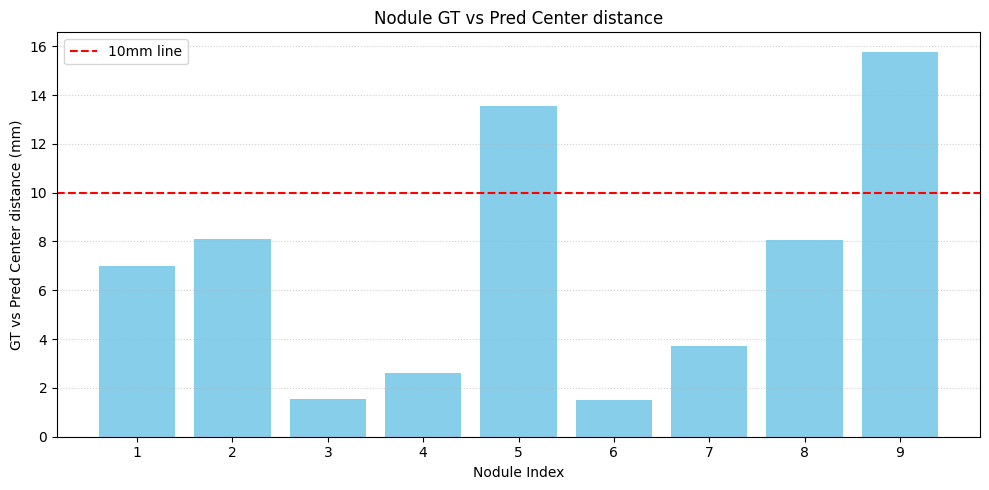

In [ ]:
results = [
    {'Z': 64, 'GT_center': (296, 386), 'Pred_center': (297, 388), 'pixel_dist': 3.37, 'mm_dist': 6.99},
    {'Z': 78, 'GT_center': (188, 361), 'Pred_center': (188, 364), 'pixel_dist': 3.35, 'mm_dist': 8.12},
    {'Z': 71, 'GT_center': (200, 314), 'Pred_center': (199, 314), 'pixel_dist': 0.64, 'mm_dist': 1.56},
    {'Z': 67, 'GT_center': (216, 365), 'Pred_center': (216, 366), 'pixel_dist': 1.28, 'mm_dist': 2.63},
    {'Z': 79, 'GT_center': (194, 335), 'Pred_center': (179, 331), 'pixel_dist': 14.62, 'mm_dist': 13.55},
    {'Z': 53, 'GT_center': (216, 390), 'Pred_center': (216, 390), 'pixel_dist': 0.63, 'mm_dist': 1.52},
    {'Z': 45, 'GT_center': (205, 135), 'Pred_center': (205, 136), 'pixel_dist': 1.73, 'mm_dist': 3.72},
    {'Z': 57, 'GT_center': (366, 164), 'Pred_center': (366, 167), 'pixel_dist': 3.28, 'mm_dist': 8.05},
    {'Z': 79, 'GT_center': (170, 326), 'Pred_center': (179, 331), 'pixel_dist': 11.27, 'mm_dist': 15.78},
]

df = pd.DataFrame(results)
df.index = [f"Nodule {i+1}" for i in range(len(df))]
print(df)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(df)+1), df['mm_dist'], color='skyblue')
plt.axhline(y=10, color='red', linestyle='--', label='10mm line')
plt.xticks(range(1, len(df)+1), [f"{i}" for i in range(1, len(df)+1)])
plt.xlabel("Nodule Index")
plt.ylabel("GT vs Pred Center distance (mm)")
plt.title("Nodule GT vs Pred Center distance")
plt.legend()
plt.grid(True, axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()